# Holt-Winters



## Import Setup


In [2]:
from matplotlib import pyplot as plt
from sklearn.metrics import *
from sklearn.model_selection import TimeSeriesSplit

from scipy.optimize import minimize         
import numpy as np

import statsmodels.formula.api as smf            
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import pandas as pd


from functools import partial

% matplotlib inline

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred)) / y_true ) * 100



## Getting Data


In [3]:
# We read the protocol traffic as a series
base_ts = pd.read_csv("../data/clean_proto_traffic.csv", index_col="timestamp").T.squeeze()

# interpolate the data close 0 to avoid 
base_ts[base_ts < 0.3e10] = np.nan
base_ts = base_ts.interpolate()

print(base_ts.head())
base_ts.describe()


timestamp
2013-02-08 09:00:00    8.664263e+09
2013-02-08 09:10:00    8.436999e+09
2013-02-08 09:20:00    1.002028e+10
2013-02-08 09:30:00    1.041861e+10
2013-02-08 09:40:00    8.689917e+09
Name: total_traffic, dtype: float64


count    2.922640e+05
mean     2.249189e+10
std      1.331581e+10
min      3.000771e+09
25%      1.250698e+10
50%      1.962429e+10
75%      2.912764e+10
max      1.017930e+11
Name: total_traffic, dtype: float64

## Theory 

## Base Smooting : Moving average
Makes a average of all point in a window

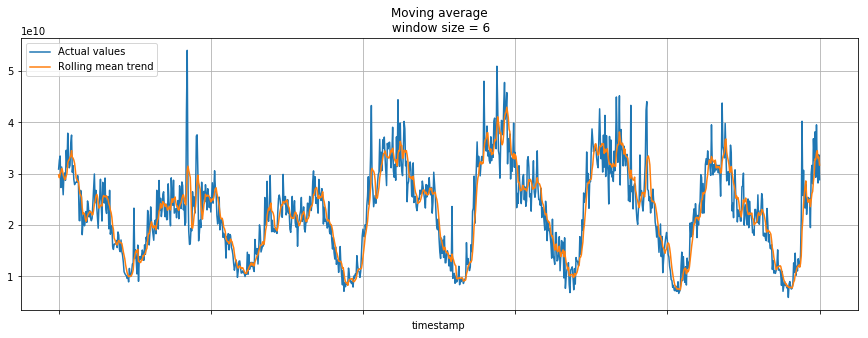

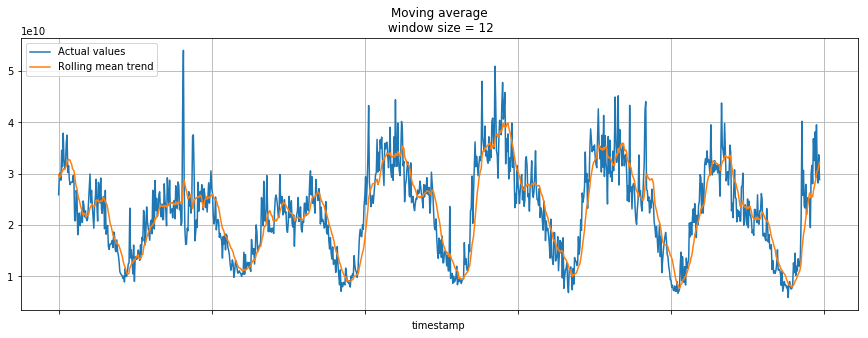

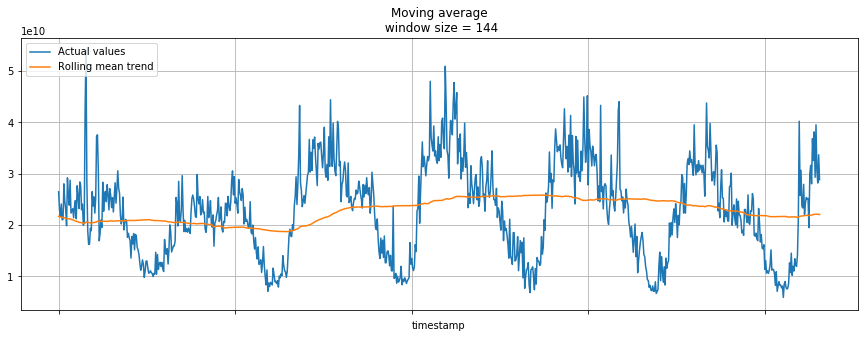

In [3]:

def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):
    rolling_mean = series.rolling(window=window).mean()
    plt.figure(figsize=(15,5))
    series[window:].plot(label="Actual values")
    rolling_mean[window:].plot(label="Rolling mean trend")
    
    plt.title("Moving average\n window size = {}".format(window))
    plt.legend(loc="upper left")
    plt.grid(True)

    
plotMovingAverage(base_ts[-1008:-1], 6)
plotMovingAverage(base_ts[-1008:-1], 12)
plotMovingAverage(base_ts[-1008:-1], 144)

## Exponential Smooting 

exponential smoothing  is similar to a mooving average, however the average is weighted. it means past observations are worth less

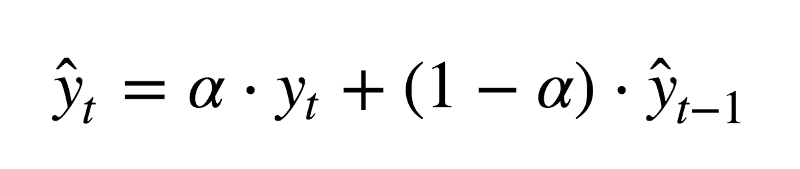

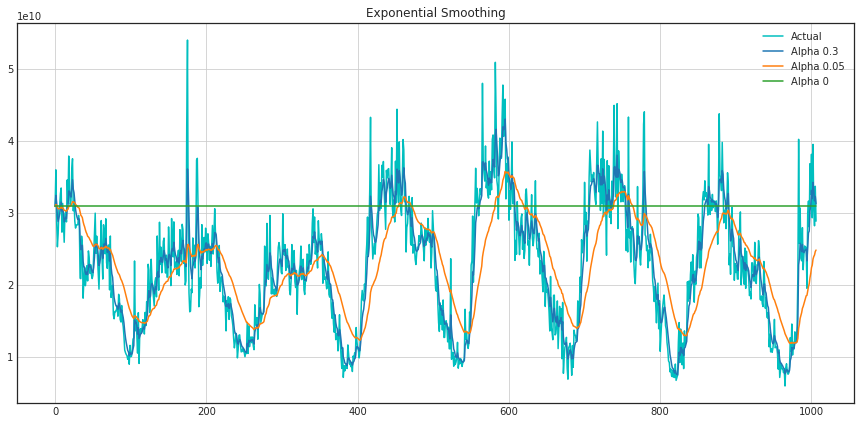

In [4]:

def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
    
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        plt.plot(series.values, "c", label = "Actual")
        
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);
        
plotExponentialSmoothing(base_ts[-1008:-1], [0.3, 0.05,0])


## Double Exponential Smooting 
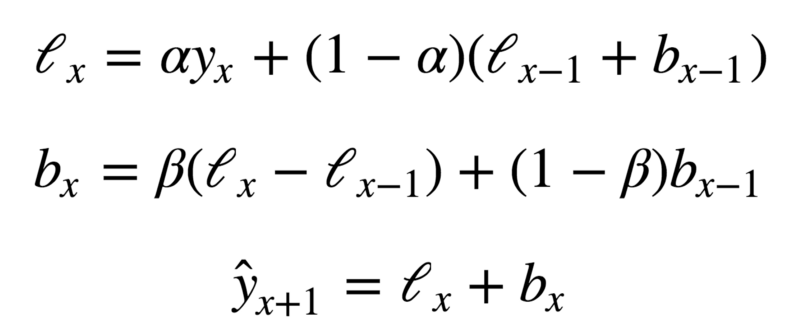


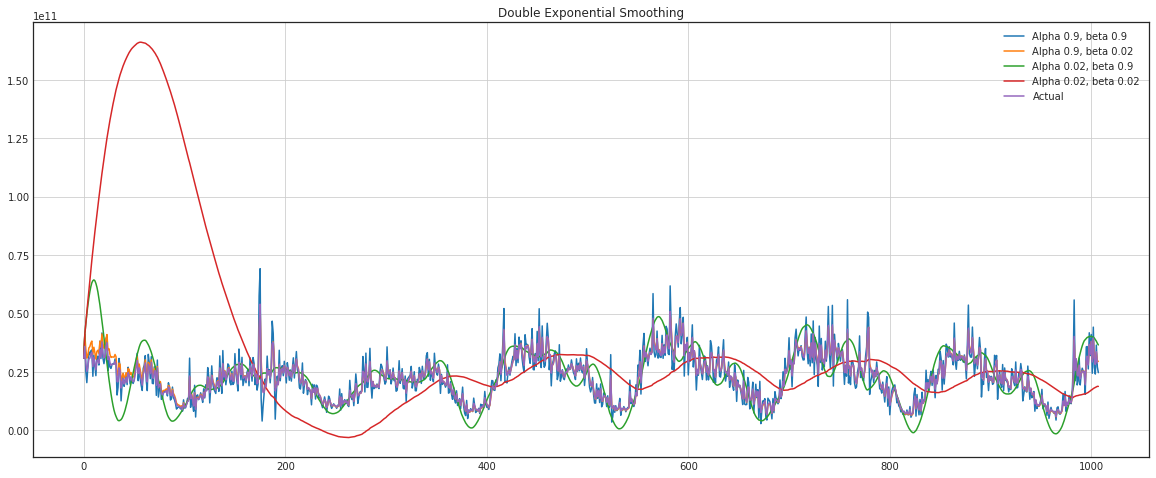

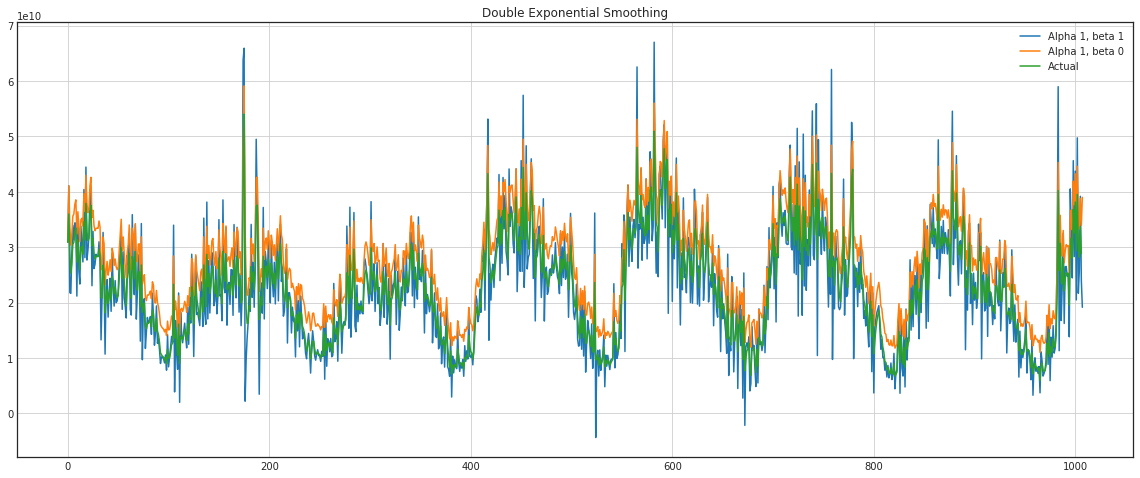

In [5]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)
        
plotDoubleExponentialSmoothing(base_ts[-1008:-1], alphas=[0.9, 0.02], betas=[0.9, 0.02])
plotDoubleExponentialSmoothing(base_ts[-1008:-1], alphas=[1], betas=[1,0])

### Holts Winter modeling
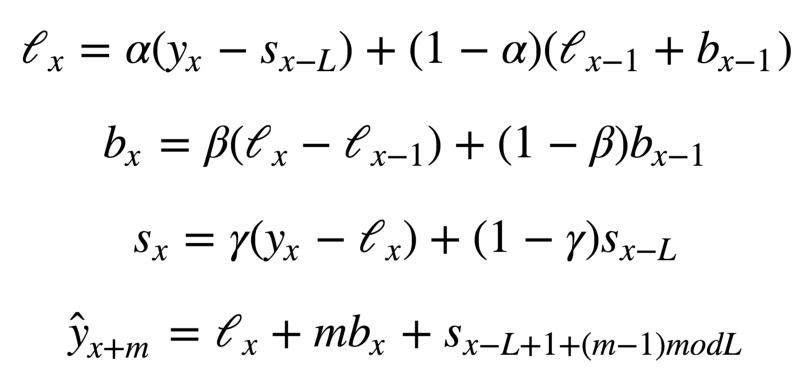

In [4]:
class HoltWinters:
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96, uncertainity=1.0007):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        self.uncertainity = uncertainity

    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i + self.slen] - self.series[i]) / self.slen
        return sum / self.slen

    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series) / self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen * j:self.slen * j + self.slen]) / float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen * j + i] - season_averages[j]
            seasonals[i] = sum_of_vals_over_avg / n_seasons
        return seasonals

    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond, self.LowerBond = [], []
        seasonals = self.initial_seasonal_components()

        for i in range(len(self.series) + self.n_preds):
            if i == 0:  # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i % self.slen])

                self.PredictedDeviation.append(0)

                self.UpperBond.append(self.result[0] +
                                      self.scaling_factor *
                                      self.PredictedDeviation[0])

                self.LowerBond.append(self.result[0] -
                                      self.scaling_factor *
                                      self.PredictedDeviation[0])
                continue

            if i >= len(self.series):  # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m * trend) + seasonals[i % self.slen])

                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1] * self.uncertainity)

            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha * (val - seasonals[i % self.slen]) + (1 - self.alpha) * (
                            smooth + trend)
                trend = self.beta * (smooth - last_smooth) + (1 - self.beta) * trend
                seasonals[i % self.slen] = self.gamma * (val - smooth) + (1 - self.gamma) * seasonals[i % self.slen]
                self.result.append(smooth + trend + seasonals[i % self.slen])

                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i])
                                               + (1 - self.gamma) * self.PredictedDeviation[-1])

            self.UpperBond.append(self.result[-1] +
                                  self.scaling_factor *
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] -
                                  self.scaling_factor *
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i % self.slen])


###  How to Optimize HoltWinters Parameters

Cross Validation Method for time series data
with those models cant be shuffled

instead we add incrementally more training data

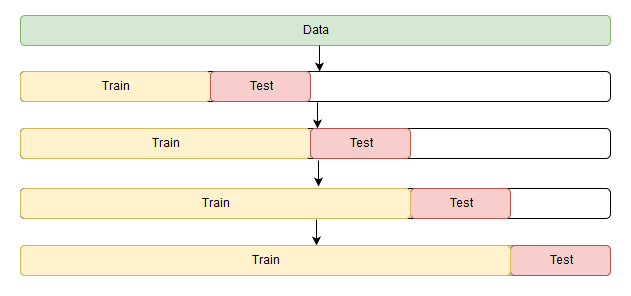

In [5]:
# Method that do a cross validation, for time series
# time series cant be shuffled like other data because of time dependencies
def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=144 * 7):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []

    values = series.values
    alpha, beta, gamma = params

    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3)

    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):
        model = HoltWinters(series=values[train], slen=slen,
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()

        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)

    return np.mean(np.array(errors))

# we do a cross validation to find to optimal alpha, beta and gamma, 
# then create an estimator to test it on different data
# the estimator is a wrapped function
def HwEstimator(data, slen=144, loss_function=mean_squared_error):
    """
    
    """
    opt = minimize(timeseriesCVscore, x0=[0, 0, 0],
                   args=(data, loss_function, slen),
                   method="TNC", bounds=((0, 1), (0, 1), (0, 1))
                   )
    print(opt.x)
    alpha_final, beta_final, gamma_final = opt.x

    minimized_holts = partial(HoltWinters, alpha=alpha_final, beta=beta_final, gamma=gamma_final)
    def estimator(*args, **kwargs):
        model = minimized_holts(slen=slen, *args, **kwargs)
        model.triple_exponential_smoothing()
        return model
    return estimator


## Holt Winter Fitting : Good Scenario

In [11]:
%%time
slen=144*7
#good
begin,end = "2017-03-01","2017-07-01"
test_begin, train, test_end = base_ts[:begin], base_ts[begin:end], base_ts[end:]

estimator = HwEstimator(train,slen=slen,loss_function=mean_squared_error)

[1.77961171e-04 2.07550637e-04 3.26162984e-01]
Wall time: 1min 24s


###   results


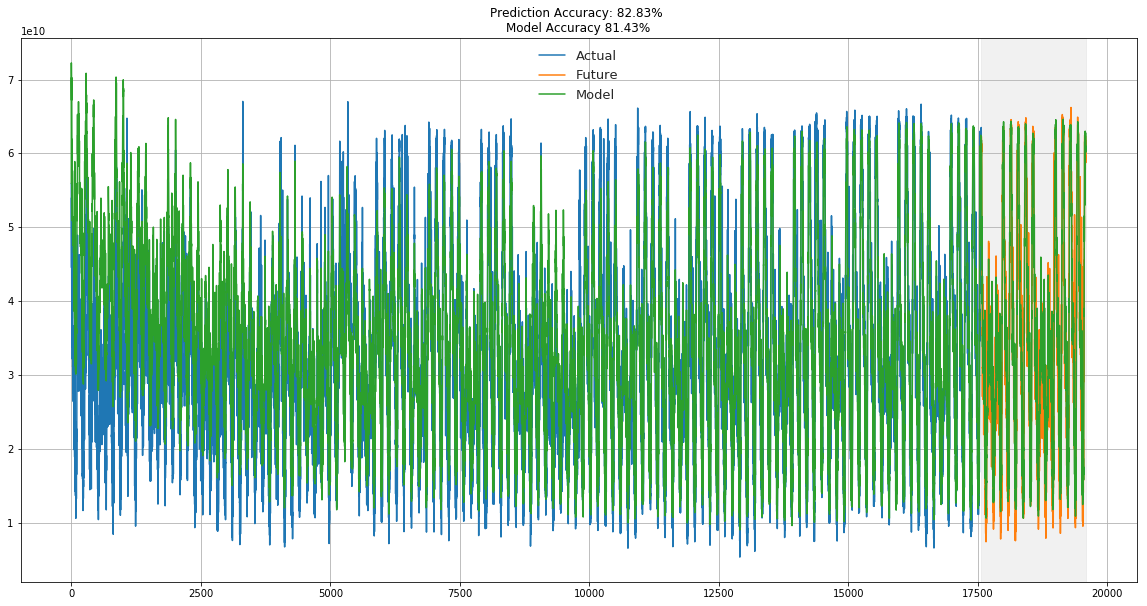

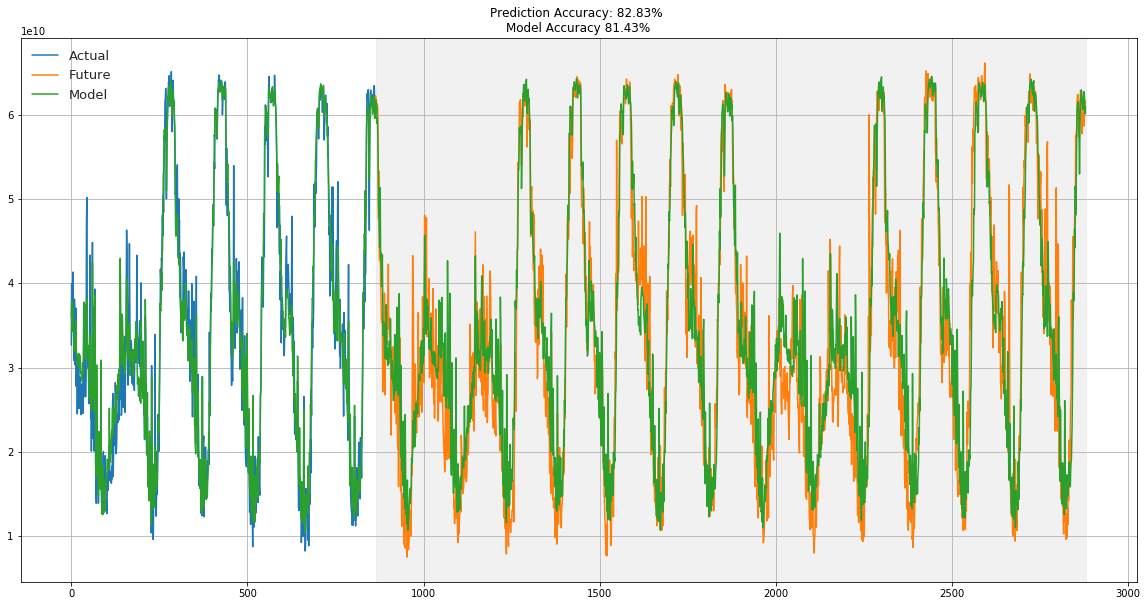

In [12]:
def plotHoltWinters(series,future,model,focus=0):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    pred_error = mean_absolute_percentage_error(future.values,  model.result[len(series):])
    model_error = mean_absolute_percentage_error(series.values,  model.result[:len(series)])
    plt.figure(figsize=(20, 10))
    plt.title("Prediction Accuracy: {0:.2f}% \n"
              "Model Accuracy {1:.2f}%".format(100 - pred_error,100 - model_error))    
    
    plt_series = series[-focus:]
    plt_future = pd.Series([np.nan]* len(plt_series),index=plt_series.index).append(future)              
    if focus:
        model.result = model.result[-(focus + len(future)):]
        model.UpperBond = model.UpperBond[-(focus + len(future)):]
        model.LowerBond = model.LowerBond[-(focus + len(future)):]
    
    model.LowerBond = [b if b >0 else 0 for b in model.LowerBond]
    
    with plt.style.context('seaborn-white'): 
        plt.plot(plt_series.values, label = "Actual")
        plt.plot(plt_future.values, label = "Future")
        plt.plot(model.result,label = "Model")

        ymin,ymax = min(model.LowerBond), max(model.UpperBond)            
        # plt.vlines(len(plt_series), ymin=ymin, ymax=ymax, linestyles='dashed')
        plt.axvspan(len(plt_series), len(model.result), alpha=0.3, color='lightgrey')
        plt.grid(True)
        plt.axis('tight')
        plt.legend(loc="best", fontsize=13);


forecast_days = 14
n_preds = 144 * forecast_days
result_good = estimator(train,n_preds=n_preds)


upcomming_data = test_end[:n_preds]
plotHoltWinters(train,upcomming_data,result_good)
plotHoltWinters(train,upcomming_data,result_good, focus=144*6)


## Holt Winter : Bad Scenario

In [13]:
%%time
#bad
begin,end = "2016-01-01","2016-07-01"
test_begin, train, test_end = base_ts[:begin], base_ts[begin:end], base_ts[end:]
estimator2 = HwEstimator(train,slen=slen,loss_function=mean_squared_error)


[0.00039718 0.00115352 0.38352348]
Wall time: 2min 3s


### results

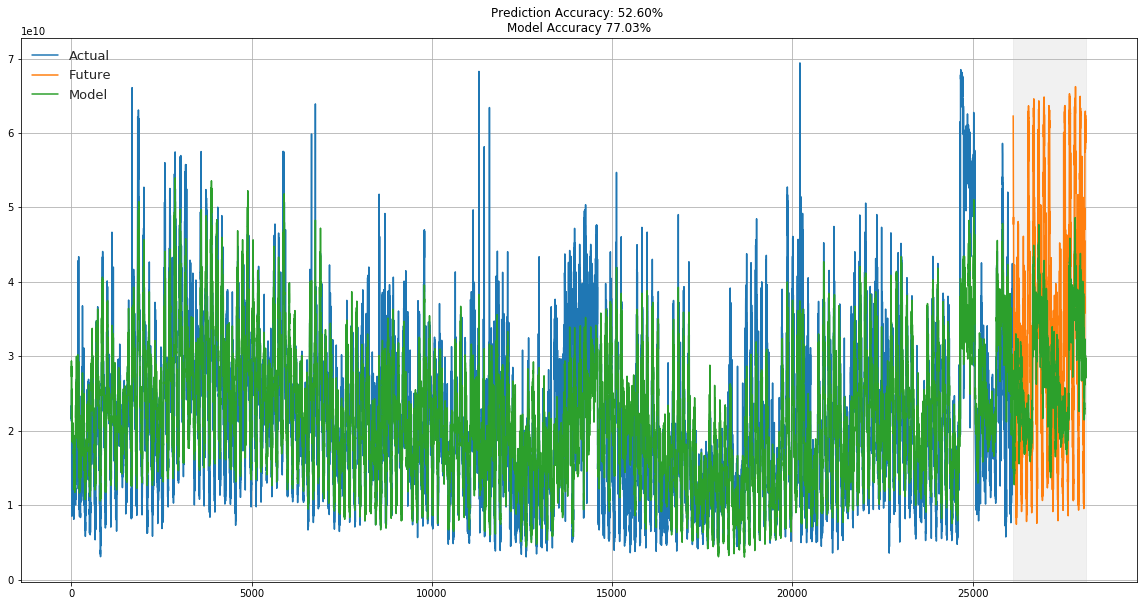

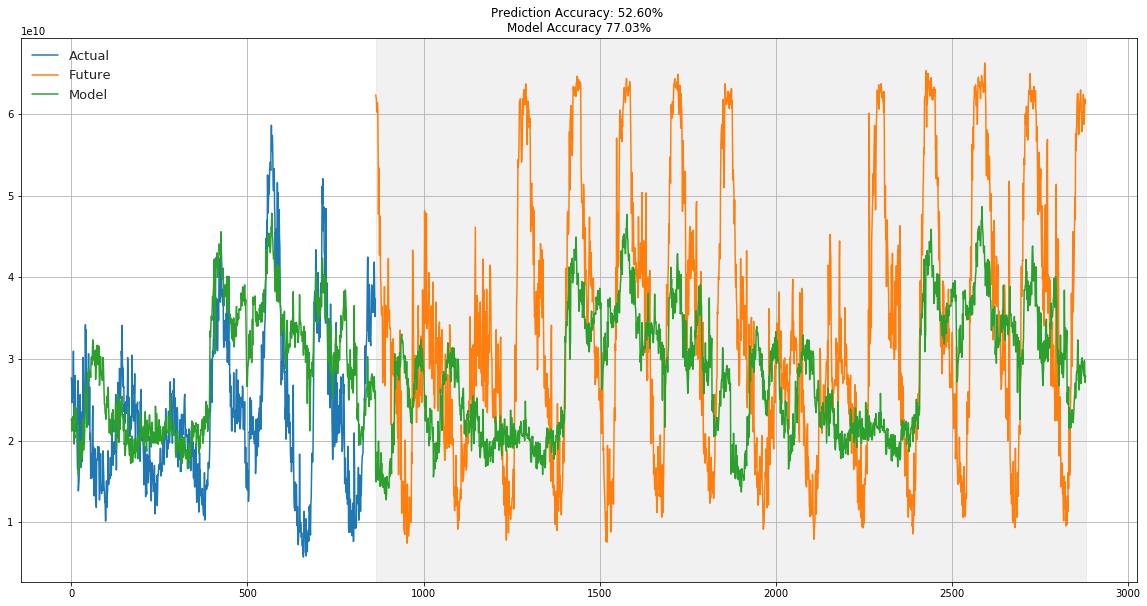

In [14]:
result_bad = estimator2(train,n_preds =n_preds)
plotHoltWinters(train,upcomming_data,result_bad)
plotHoltWinters(train,upcomming_data,result_bad, focus=144*6)  

## Holt-Winter Smoothing with all Data

[8.44540417e-07 5.26942313e-04 0.00000000e+00]
Wall time: 22min 13s


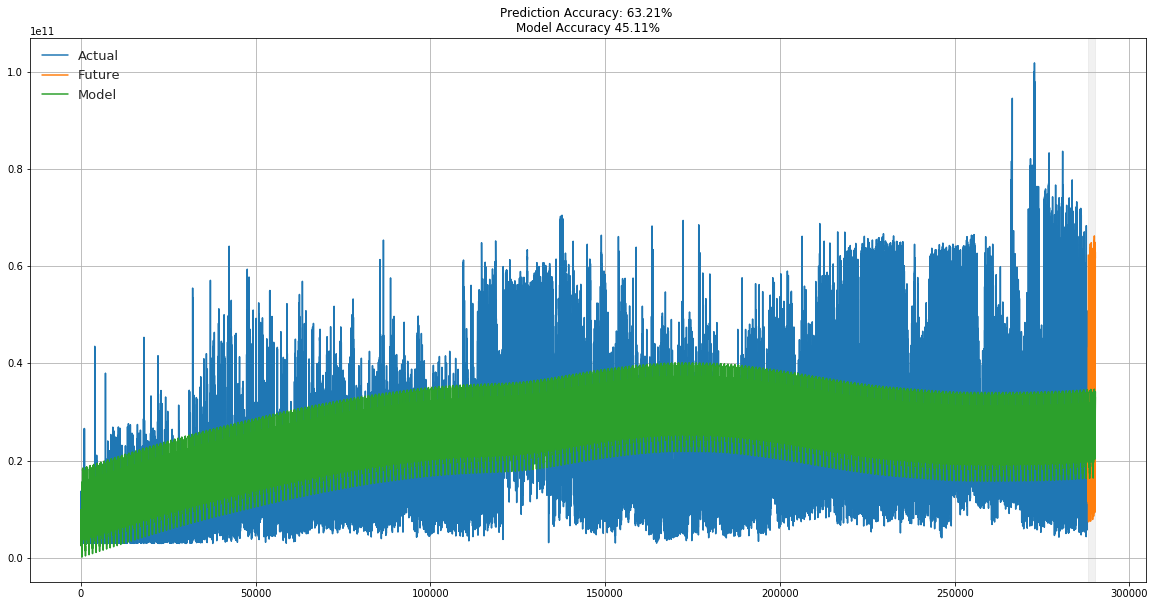

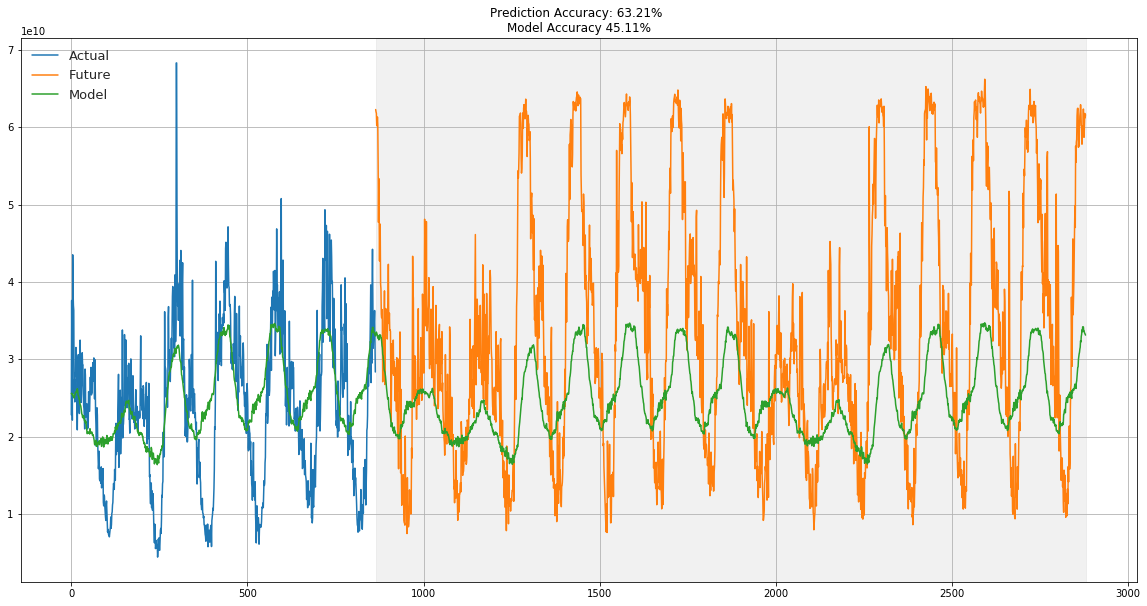

In [12]:
%%time
# SHows that statistical model can also suffer heavily from scalibility
begin,end = 0,-1008 * 4
test_begin, train, test_end = base_ts[:begin], base_ts[begin:end], base_ts[end:]
estimator3 = HwEstimator(train,slen=slen,loss_function=mean_squared_error)
result_bad = estimator3(train,n_preds =n_preds)
plotHoltWinters(train,upcomming_data,result_bad)
plotHoltWinters(train,upcomming_data,result_bad, focus=144*6)  